# Thực hiện đọc dữ liệu từ hdfs

Dữ liệu đã được lưu trữ trên hdfs, hiện tại ta cần sử dụng pyspark để đọc dữ liệu ra và xử lý. Cụm spark đã được bật, ta có thể xem thông tin của cả cụm trên web ui host post của spark-master là 0.0.0.0:8080 (truy cập qua localhost) hoặc 172.19.0.2:8080 (truy cập qua ip của container trong docker, xem thông tin bằng lệnh docker network inspect).

In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from IPython.display import Image

In [2]:
#Truy cập vào master của cụm tại địa chỉ 172.19.0.4:7077 với tên chương trình là Stock_price_analysis
spark = SparkSession.builder.master("spark://spark-master:7077").appName("Stock_price_analysis").getOrCreate()

Ta có thể  truy cập vào địa chỉ web ui của spark-master để xem thông tin của chương trình đang chạy

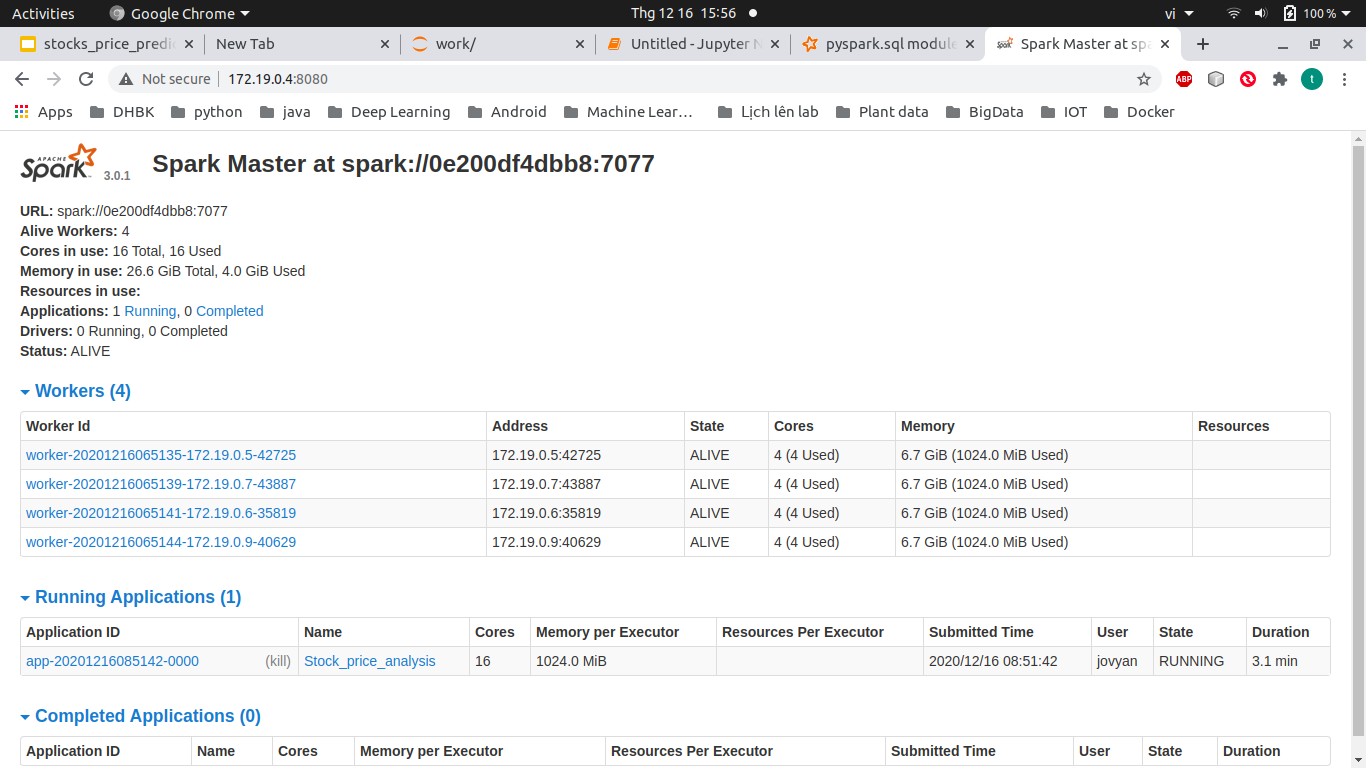

In [3]:
Image("spark_app.png")

Tiếp theo ta sẽ sử dụng spark session vừa tạo để truy cập vào hdfs và lấy dữ liệu ra để xử lý. Cụ thể ta sẽ truy cập vào địa chỉ của namenode trên hdfs là namenode:9000 

# Một số phân tích cơ bản

Toàn bộ dữ liệu của thị trường chứng khoán Việt Nam được thu thập từ API của VnStock bao gồm 1685 công ty. Dữ liệu của mỗi côn V và bao gồm 5 trường: Date (ngày giao dịch), Open (giá mở 
cửa), High (giá cao nhất), Low (giá thấp nhất), Close (giá đón).  Để hiểu rõ hơn về hành vi của thị trường chứng khoán Việt Nam, dự án này đã tiến hành
phân tích dữ liệu lịch sử từ 5 cổ phiếu lớn trên thị trường chứng khoán Việt Namtừ 
các lĩnh vực khác nhau, bao g:n:

#### Vingroup (mã VIC)

#### Vinhomes (mã VHM)

#### Vietcombank (mã VCB) 

#### Vinamilk (mã VNM) 

#### Masan (mã MSN)


In [4]:
df_VIC = spark.read.format("csv").option("header", "true")\
.option("inferSchema", "true").load("hdfs://namenode:9000/user/root/datackvn/stock_market_data-VIC_2025-10-26.csv")

df_HPG = spark.read.format("csv").option("header", "true")\
.option("inferSchema", "true").load("hdfs://namenode:9000/user/root/datackvn/stock_market_data-HPG_2025-10-26.csv")

df_VCB = spark.read.format("csv").option("header", "true")\
.option("inferSchema", "true").load("hdfs://namenode:9000/user/root/datackvn/stock_market_data-VCB_2025-10-26.csv")

df_FPT = spark.read.format("csv").option("header", "true")\
.option("inferSchema", "true").load("hdfs://namenode:9000/user/root/datackvn/stock_market_data-FPT_2025-10-26.csv")

df_MSN = spark.read.format("csv").option("header", "true")\
.option("inferSchema", "true").load("hdfs://namenode:9000/user/root/datackvn/stock_market_data-MSN_2025-10-26.csv")

## Phân tích xu hướng (Trend Analysis)

### Phân tích giá trung bình hàng ngày (Stock Daily Mean Price)

Sau khi lấy dữ liệu, ta thực hiện việc thêm cột Mean để tìm trung bình của mã chứng khoán trong ngày.

Từ đó ta vẽ được biểu đồ để so sánh các mã chứng khoán.

In [5]:
from pyspark.sql.functions import year, expr
import matplotlib.pyplot as plt
import pandas as pd

df_VICmean = df_VIC.withColumn("Mean", expr('(High+Low)/2'))
df_HPGmean = df_HPG.withColumn("Mean", expr('(High+Low)/2'))
df_VCBmean = df_VCB.withColumn("Mean", expr('(High+Low)/2'))
df_FPTmean = df_FPT.withColumn("Mean", expr('(High+Low)/2'))
df_MSNmean = df_MSN.withColumn("Mean", expr('(High+Low)/2'))

Để dễ sử dụng thư viện đồ thị matplotlib, ta chuyển các dữ liệu dataframes về dạng pandas.


In [6]:
df_VICmean = df_VICmean.toPandas()
df_HPGmean = df_HPGmean.toPandas()
df_VCBmean = df_VCBmean.toPandas()
df_FPTmean = df_FPTmean.toPandas()
df_MSNmean = df_MSNmean.toPandas()

Kết quả so sánh chỉ số trung bình trong ngày của các mã nói trên trong đồ thị

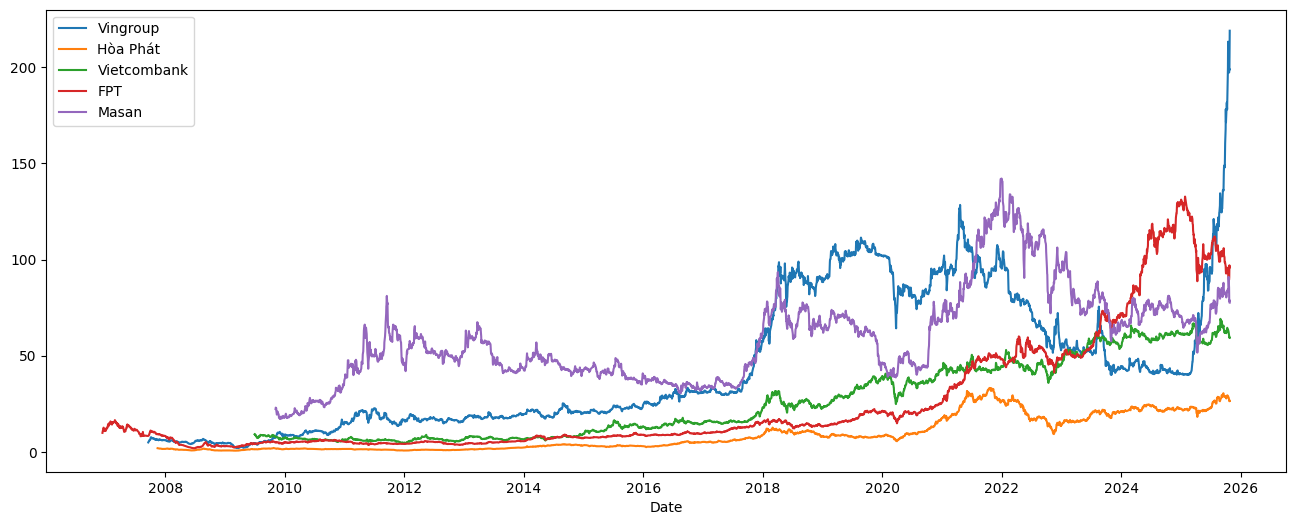

In [7]:
ax = df_VICmean.plot(x='Date', y='Mean', label='Vingroup', figsize=(16,6))
ax = df_HPGmean.plot(ax=ax, x='Date', y='Mean', label='Hòa Phát')
ax = df_VCBmean.plot(ax=ax, x='Date', y='Mean', label='Vietcombank')
ax = df_FPTmean.plot(ax=ax, x='Date', y='Mean', label='FPT')
ax = df_MSNmean.plot(ax=ax, x='Date', y='Mean', label='Masan')

### Phân tích xu hướng với Đường Trung bình Động (Moving Averages)

Phân tích này sử dụng các đường trung bình động đơn giản (Simple Moving Averages) để làm mượt các biến động giá ngắn hạn, qua đó giúp chúng ta xác định rõ ràng hơn xu hướng cơ bản của cổ phiếu theo thời gian.

In [8]:
df_VICmean['Date'] = pd.to_datetime(df_VICmean['Date'])
df_HPGmean['Date'] = pd.to_datetime(df_HPGmean['Date'])
df_VCBmean['Date'] = pd.to_datetime(df_VCBmean['Date'])
df_FPTmean['Date'] = pd.to_datetime(df_FPTmean['Date'])
df_MSNmean['Date'] = pd.to_datetime(df_MSNmean['Date'])

df_VICmean = df_VICmean.sort_values('Date')
df_HPGmean = df_HPGmean.sort_values('Date')
df_VCBmean = df_VCBmean.sort_values('Date')
df_FPTmean = df_FPTmean.sort_values('Date')
df_MSNmean = df_MSNmean.sort_values('Date')

# SMA 50 ngày (phản ánh xu hướng trung hạn)
df_VICmean['SMA_50'] = df_VICmean['Mean'].rolling(window=50).mean()
df_HPGmean['SMA_50'] = df_HPGmean['Mean'].rolling(window=50).mean()
df_VCBmean['SMA_50'] = df_VCBmean['Mean'].rolling(window=50).mean()
df_FPTmean['SMA_50'] = df_FPTmean['Mean'].rolling(window=50).mean()
df_MSNmean['SMA_50'] = df_MSNmean['Mean'].rolling(window=50).mean()

# SMA 200 ngày (phản ánh xu hướng dài hạn)
df_VICmean['SMA_200'] = df_VICmean['Mean'].rolling(window=200).mean()
df_HPGmean['SMA_200'] = df_HPGmean['Mean'].rolling(window=200).mean()
df_VCBmean['SMA_200'] = df_VCBmean['Mean'].rolling(window=200).mean()
df_FPTmean['SMA_200'] = df_FPTmean['Mean'].rolling(window=200).mean()
df_MSNmean['SMA_200'] = df_MSNmean['Mean'].rolling(window=200).mean()

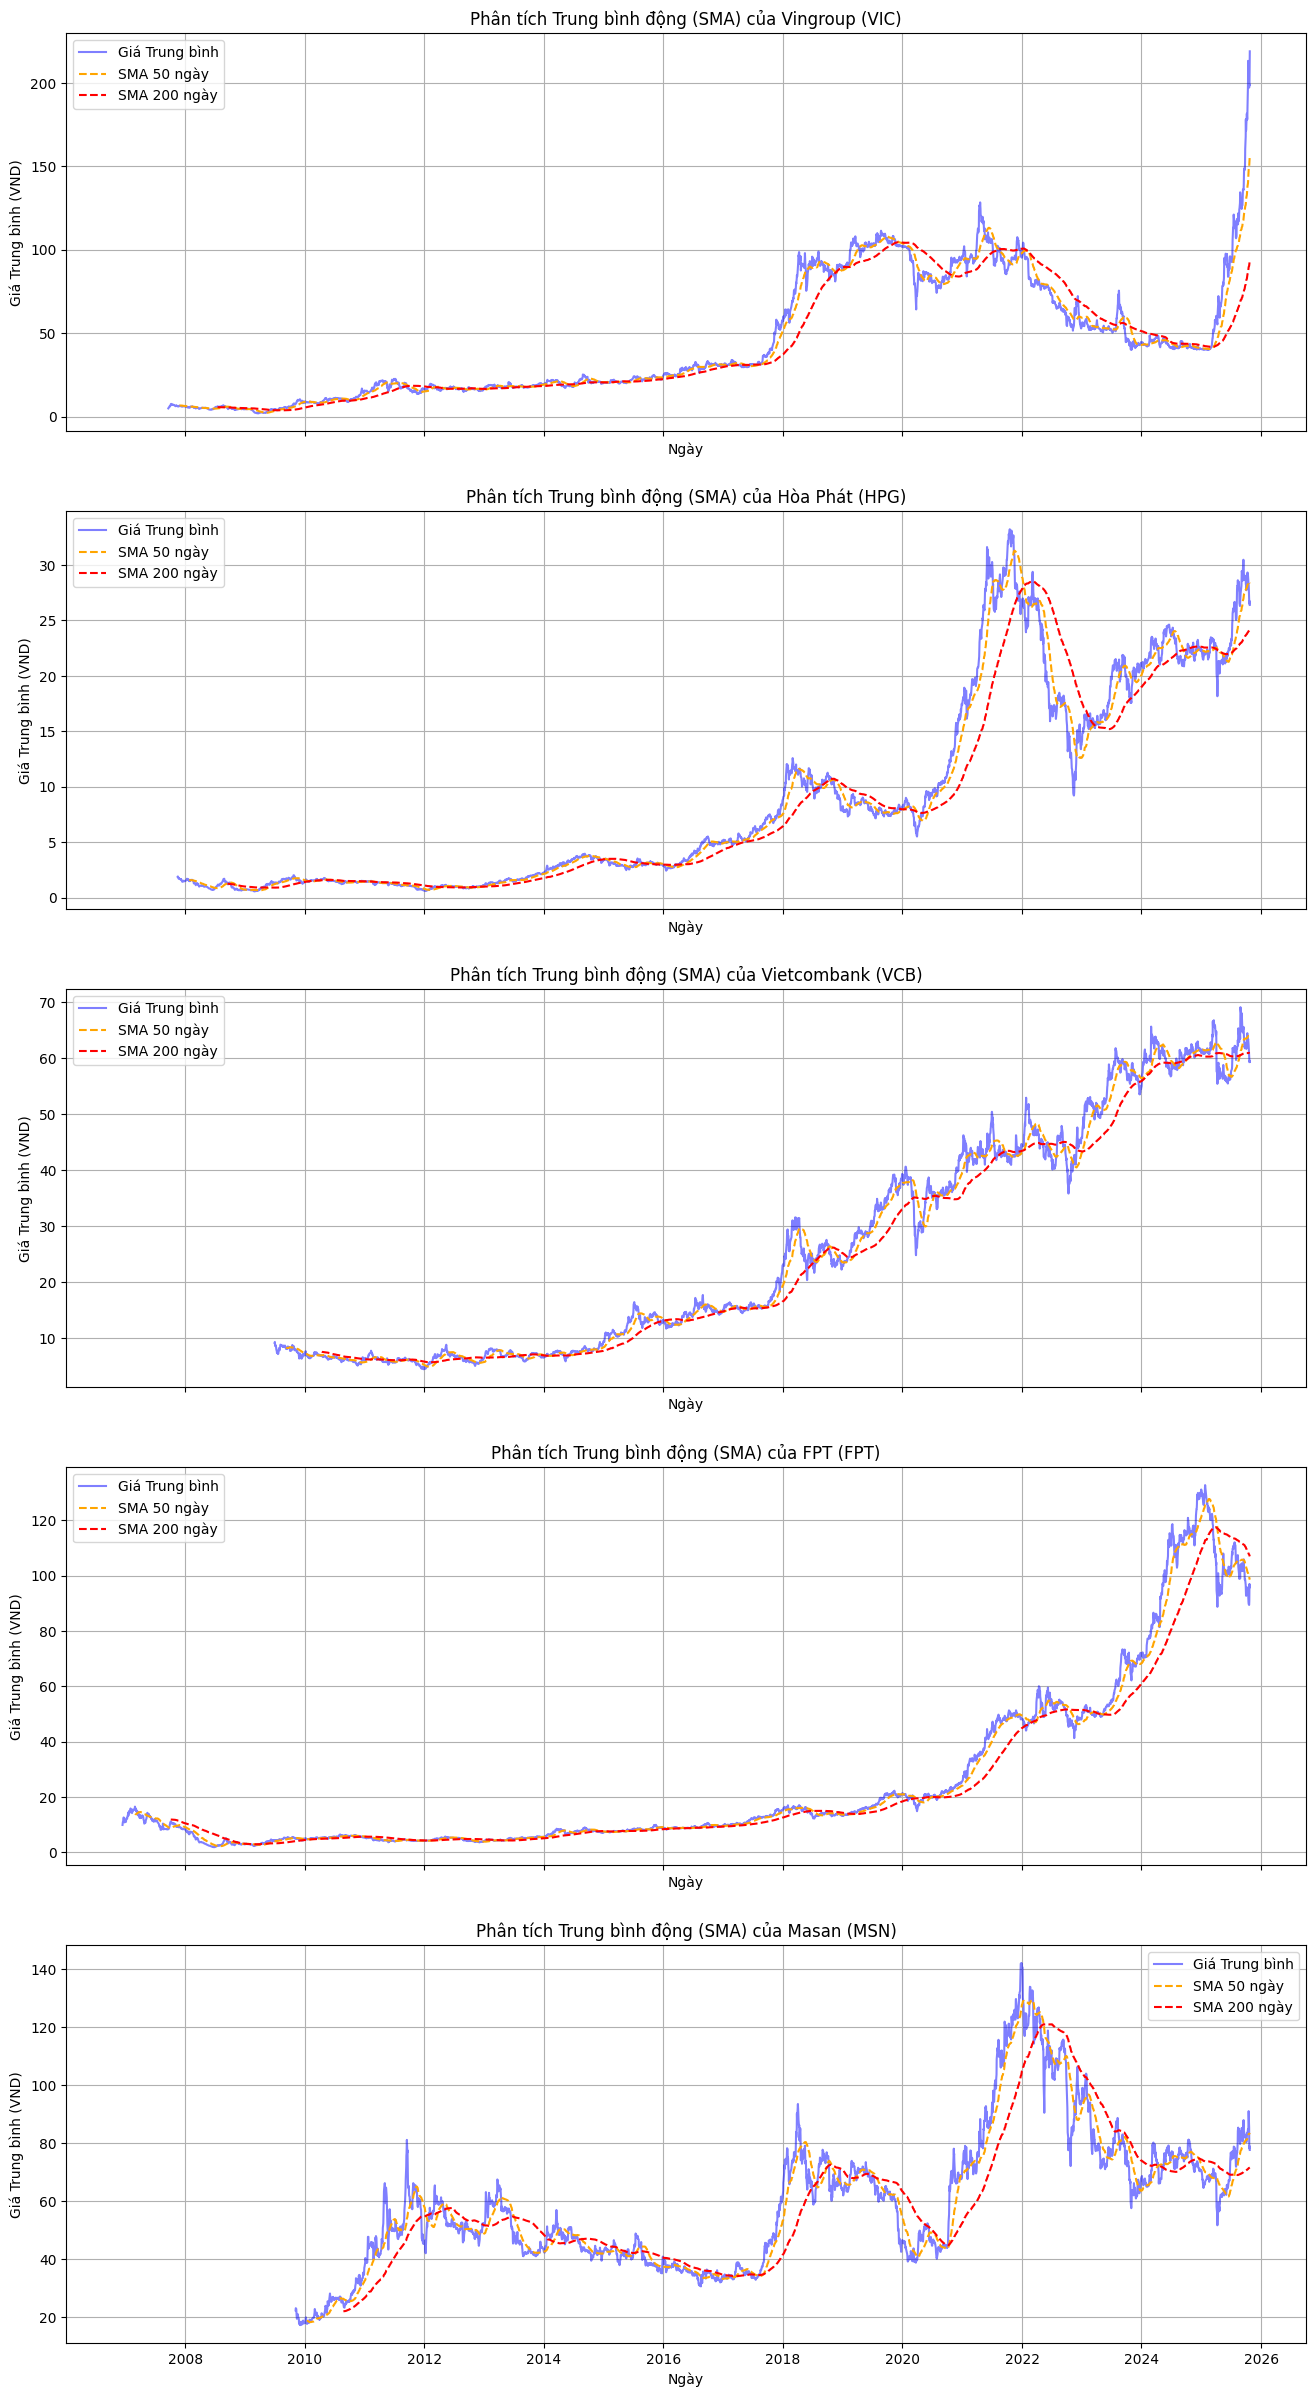

In [9]:
dfs = [df_VICmean, df_HPGmean, df_VCBmean, df_FPTmean, df_MSNmean]
titles = ['Vingroup (VIC)', 'Hòa Phát (HPG)', 'Vietcombank (VCB)', 'FPT (FPT)', 'Masan (MSN)']
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(16, 30), sharex=True)

for i in range(len(dfs)):
    ax = axes[i]
    df = dfs[i]
    title = titles[i]    
    ax.plot(df['Date'], df['Mean'], label='Giá Trung bình', color='blue', alpha=0.5)
    ax.plot(df['Date'], df['SMA_50'], label='SMA 50 ngày', color='orange', linestyle='--')
    ax.plot(df['Date'], df['SMA_200'], label='SMA 200 ngày', color='red', linestyle='--')
    ax.set_title(f'Phân tích Trung bình động (SMA) của {title}')
    ax.set_xlabel('Ngày')
    ax.set_ylabel('Giá Trung bình (VND)')
    ax.legend()
    ax.grid(True)

## Phân tích biến động (Volatility Analysis)

### Phân tích biến động từ tỷ suất sinh lợi hàng ngày (Volatility Daily Percentage Return)

Ta thực hiện việc thêm cột Change để tìm tỷ lệ thay đổi của mã chứng khoán.

In [10]:
df_VICmean['Change'] = (df_VICmean['Close']/df_VICmean['Close'].shift(1)) - 1
df_HPGmean['Change'] = (df_HPGmean['Close']/df_HPGmean['Close'].shift(1)) - 1
df_VCBmean['Change'] = (df_VCBmean['Close']/df_VCBmean['Close'].shift(1)) - 1
df_FPTmean['Change'] = (df_FPTmean['Close']/df_FPTmean['Close'].shift(1)) - 1
df_MSNmean['Change'] = (df_MSNmean['Close']/df_MSNmean['Close'].shift(1)) - 1

Sau đó, ta vẽ biểu đồ cột thể hiện sự thay đổi của các mã theo ngày

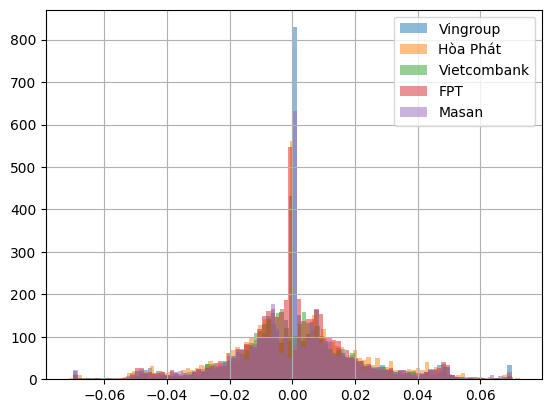

In [11]:
import matplotlib.pyplot as plt

df_VICmean['Change'].hist(bins=100, label='Vingroup',alpha=0.5)
df_HPGmean['Change'].hist(bins=100, label='Hòa Phát',alpha=0.5)
df_VCBmean['Change'].hist(bins=100, label='Vietcombank',alpha=0.5)
df_FPTmean['Change'].hist(bins=100, label='FPT',alpha=0.5)
df_MSNmean['Change'].hist(bins=100, label='Masan',alpha=0.5)

plt.legend()

Biểu đồ trên thể hiện sự biến động của từng mã. Số lượng gần 0 càng nhiều chứng tỏ là mã càng biến động ít và ngược lại.

Ta vẽ biểu đồ đường để miêu tả rõ hơn điều đó

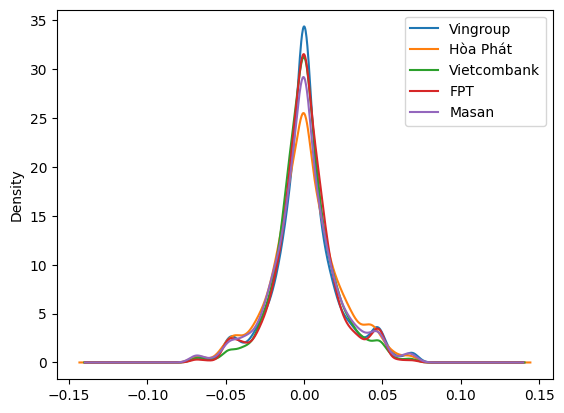

In [12]:
df_VICmean['Change'].plot(kind= 'kde', label = 'Vingroup')
df_HPGmean['Change'].plot(kind= 'kde', label = 'Hòa Phát')
df_VCBmean['Change'].plot(kind= 'kde', label = 'Vietcombank')
df_FPTmean['Change'].plot(kind= 'kde', label = 'FPT')
df_MSNmean['Change'].plot(kind= 'kde', label = 'Masan')

plt.legend()

Từ biểu đồ trên, ta thấy sự biến động của các mã đều gần giống với phân phối chuẩn có giá trị trung bình là 0.

### Phân tích biến động theo thời gian (Volatility Over Time)

In [13]:
df_VICmean['Volatility_30d'] = df_VICmean['Change'].rolling(window=30).std()
df_HPGmean['Volatility_30d'] = df_HPGmean['Change'].rolling(window=30).std()
df_VCBmean['Volatility_30d'] = df_VCBmean['Change'].rolling(window=30).std()
df_FPTmean['Volatility_30d'] = df_FPTmean['Change'].rolling(window=30).std()
df_MSNmean['Volatility_30d'] = df_MSNmean['Change'].rolling(window=30).std()

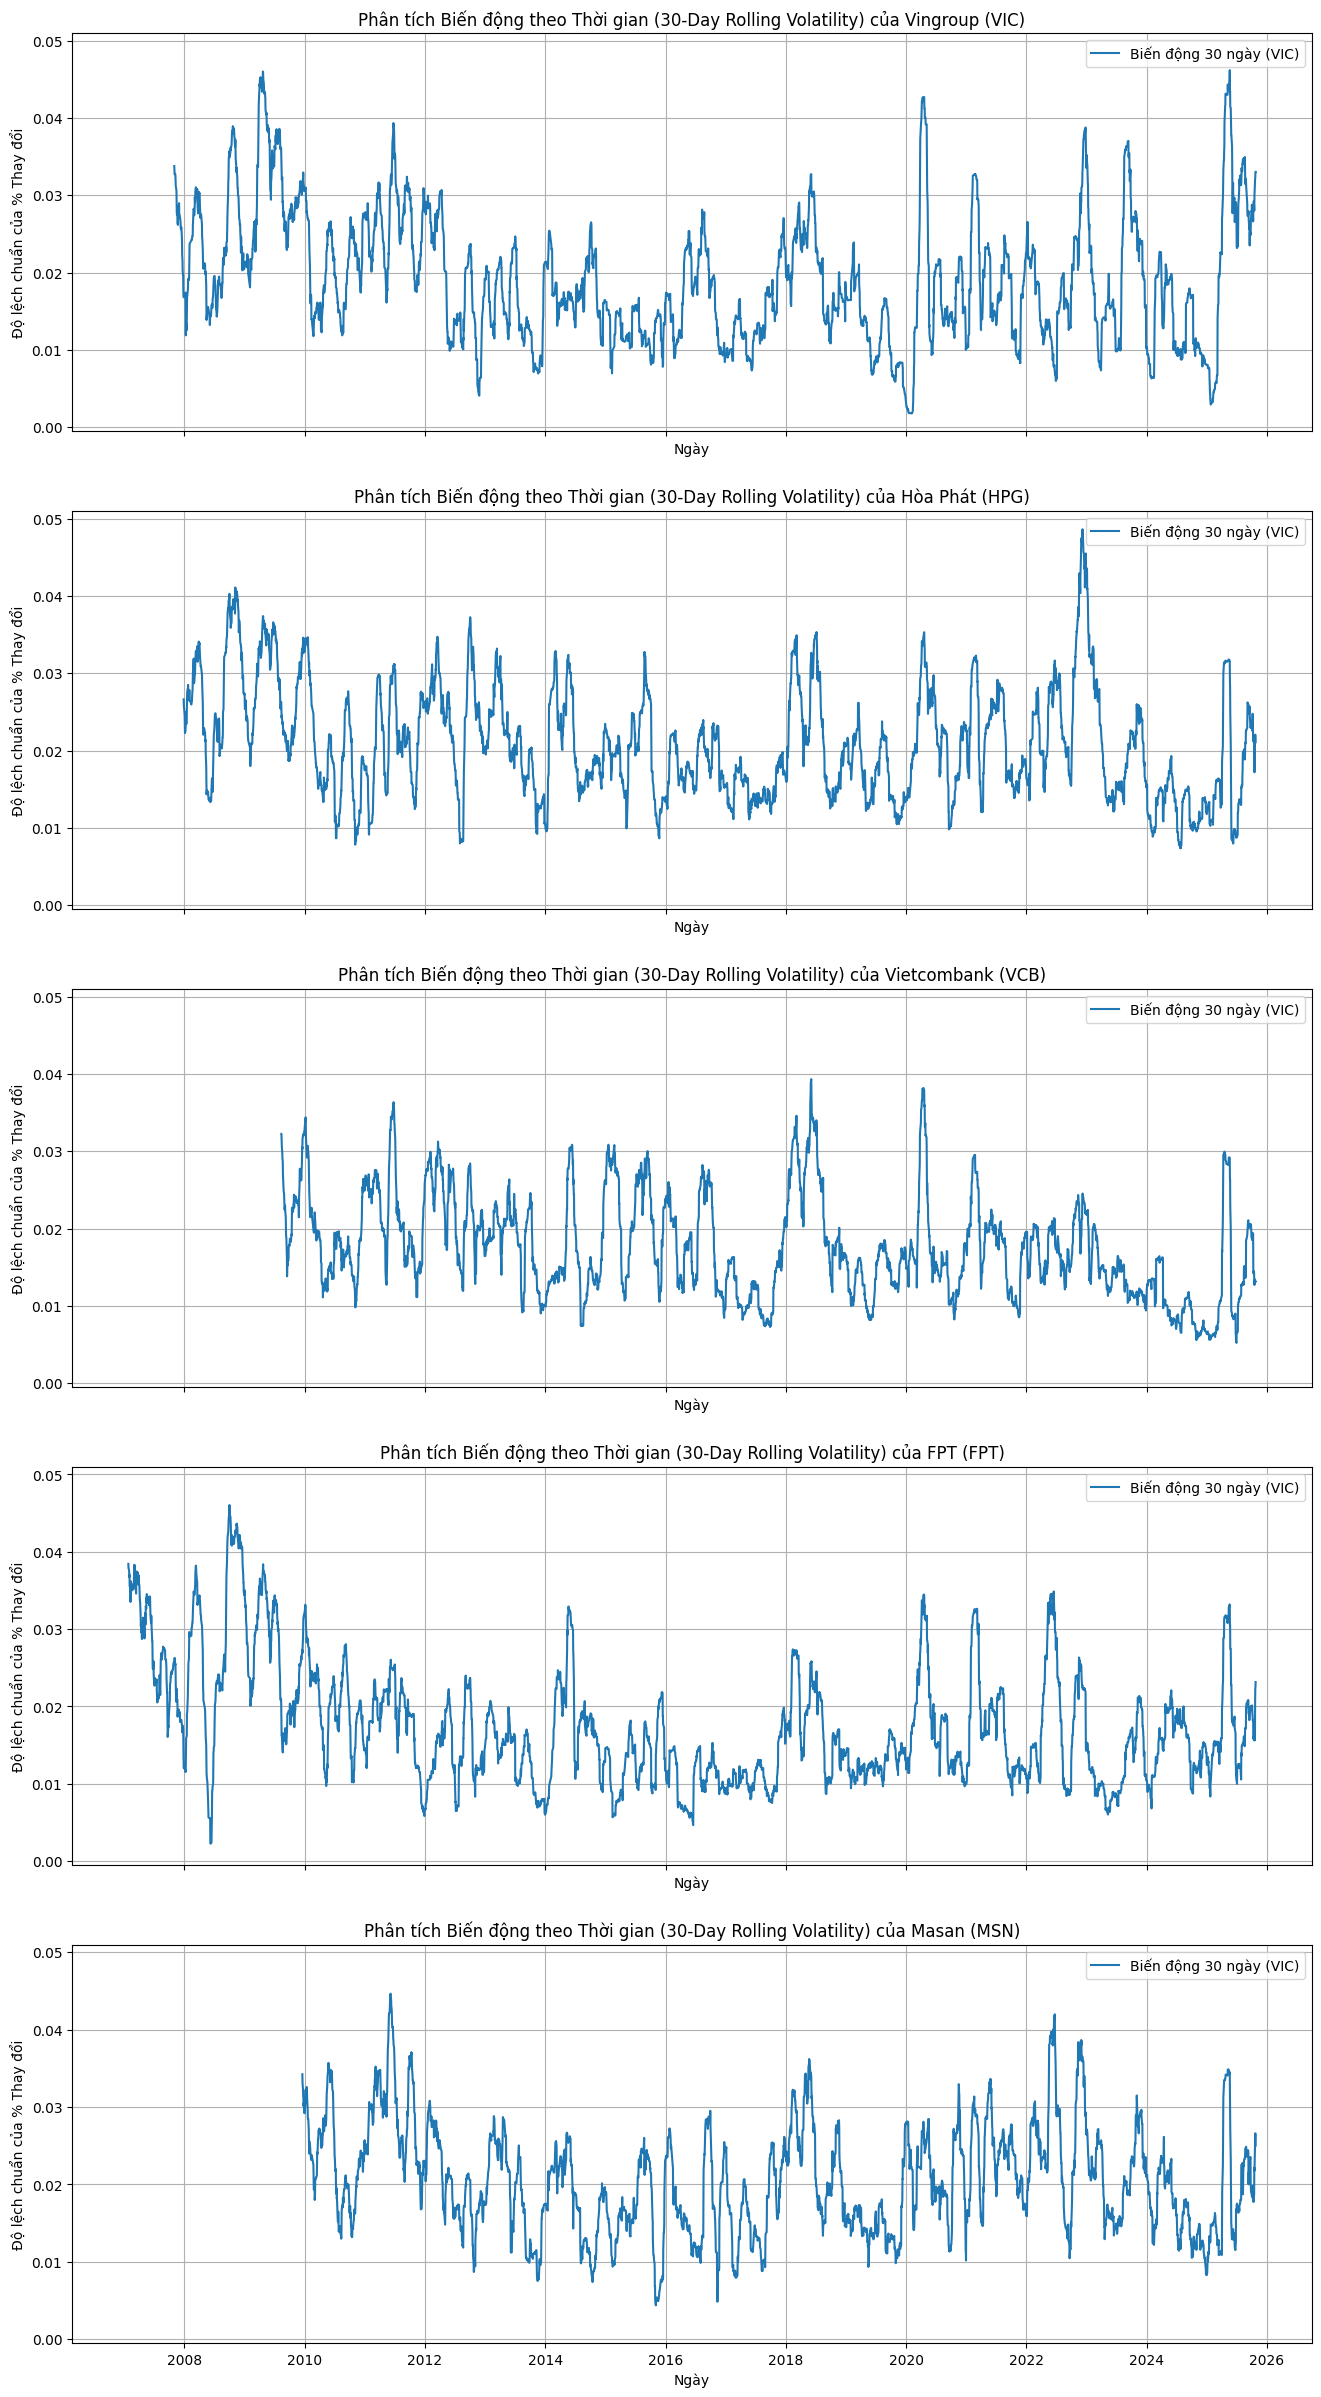

In [14]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(16, 30), sharex=True, sharey = True)

for i in range(len(dfs)):
    ax = axes[i]
    df = dfs[i]
    title = titles[i]    
    ax.plot(df['Date'], df['Volatility_30d'], label='Biến động 30 ngày (VIC)')
    ax.set_title(f'Phân tích Biến động theo Thời gian (30-Day Rolling Volatility) của {title}')
    ax.set_xlabel('Ngày')
    ax.set_ylabel('Độ lệch chuẩn của % Thay đổi')
    ax.legend()
    ax.grid(True)

## Phân tích tương quan (Correlation Analysis)

### Phân tích rủi ro và lợi nhuận

In [15]:
dfs_dic = [
    (df_VICmean, 'VIC'),
    (df_HPGmean, 'HPG'),
    (df_VCBmean, 'VCB'),
    (df_FPTmean, 'FPT'),
    (df_MSNmean, 'MSN')
]

risk_return_data = []
for df, name in dfs_dic:
    avg_return = df['Change'].mean() * 100
    risk = df['Change'].std() * 100
    risk_return_data.append((avg_return, risk, name))


df_risk_return = pd.DataFrame(risk_return_data, columns=['Lợi nhuận TB (%)', 'Rủi ro (%)', 'Mã CK'])
print(df_risk_return)

   Lợi nhuận TB (%)  Rủi ro (%) Mã CK
0          0.106618    2.115322   VIC
1          0.082712    2.237540   HPG
2          0.063689    1.882719   VCB
3          0.067479    1.934081   FPT
4          0.055325    2.165947   MSN


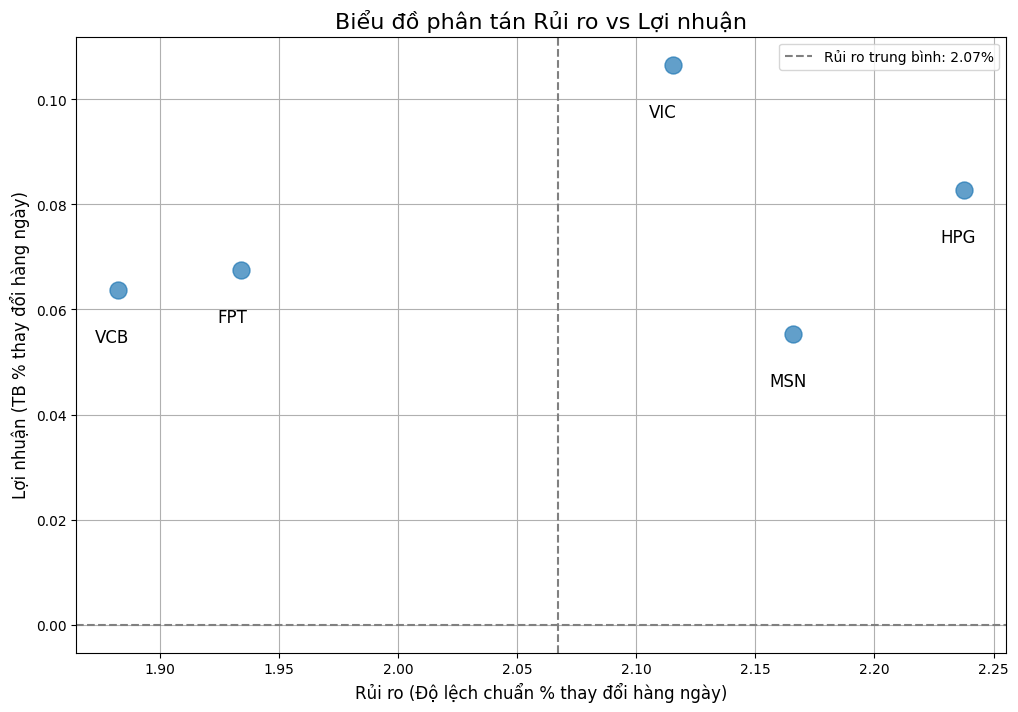

In [16]:
plt.figure(figsize=(12, 8))
plt.scatter(df_risk_return['Rủi ro (%)'], df_risk_return['Lợi nhuận TB (%)'], s=150, alpha=0.7)

for i, row in df_risk_return.iterrows():
    plt.annotate(row['Mã CK'], 
                 (row['Rủi ro (%)'] - 0.01, row['Lợi nhuận TB (%)'] - 0.01),
                 fontsize=12)

plt.axhline(0, color='grey', linestyle='--')
plt.axvline(df_risk_return['Rủi ro (%)'].mean(), color='grey', linestyle='--', label=f"Rủi ro trung bình: {df_risk_return['Rủi ro (%)'].mean():.2f}%")
plt.title('Biểu đồ phân tán Rủi ro vs Lợi nhuận', fontsize=16)
plt.xlabel('Rủi ro (Độ lệch chuẩn % thay đổi hàng ngày)', fontsize=12)
plt.ylabel('Lợi nhuận (TB % thay đổi hàng ngày)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

### Ma trận tương quan (Correlation Heatmap)

In [17]:
import seaborn as sns

df_changes = pd.DataFrame({
    'VIC': df_VICmean['Change'],
    'HPG': df_HPGmean['Change'],
    'FPT': df_FPTmean['Change'],
    'VCB': df_VCBmean['Change'],
    'MSN': df_MSNmean['Change']
})

corr_matrix = df_changes.corr()
print(corr_matrix)

          VIC       HPG       FPT       VCB       MSN
VIC  1.000000  0.330573  0.309659  0.272397  0.226109
HPG  0.330573  1.000000  0.512006  0.455476  0.317446
FPT  0.309659  0.512006  1.000000  0.410538  0.290695
VCB  0.272397  0.455476  0.410538  1.000000  0.304600
MSN  0.226109  0.317446  0.290695  0.304600  1.000000


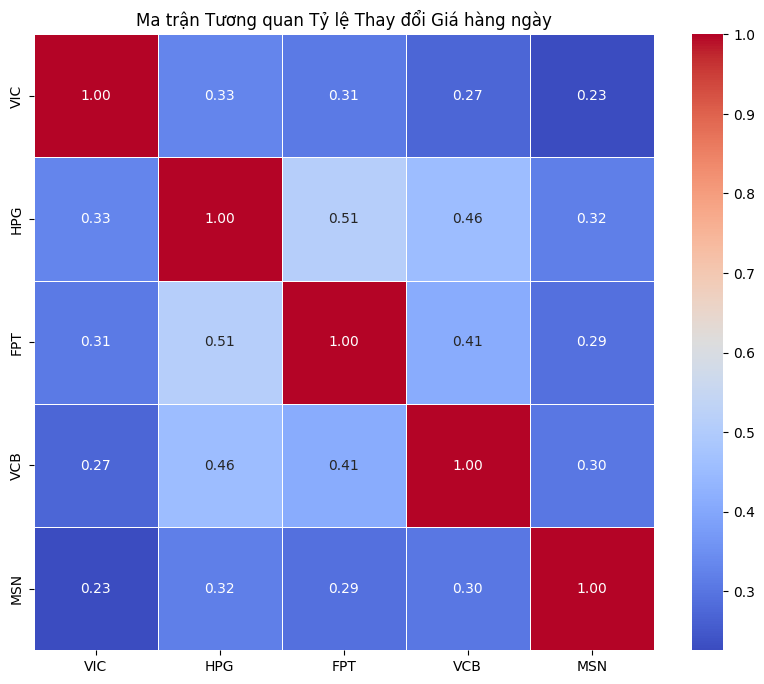

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Ma trận Tương quan Tỷ lệ Thay đổi Giá hàng ngày')
plt.show()

## Phân tích Động lượng (Momentum Analysis)

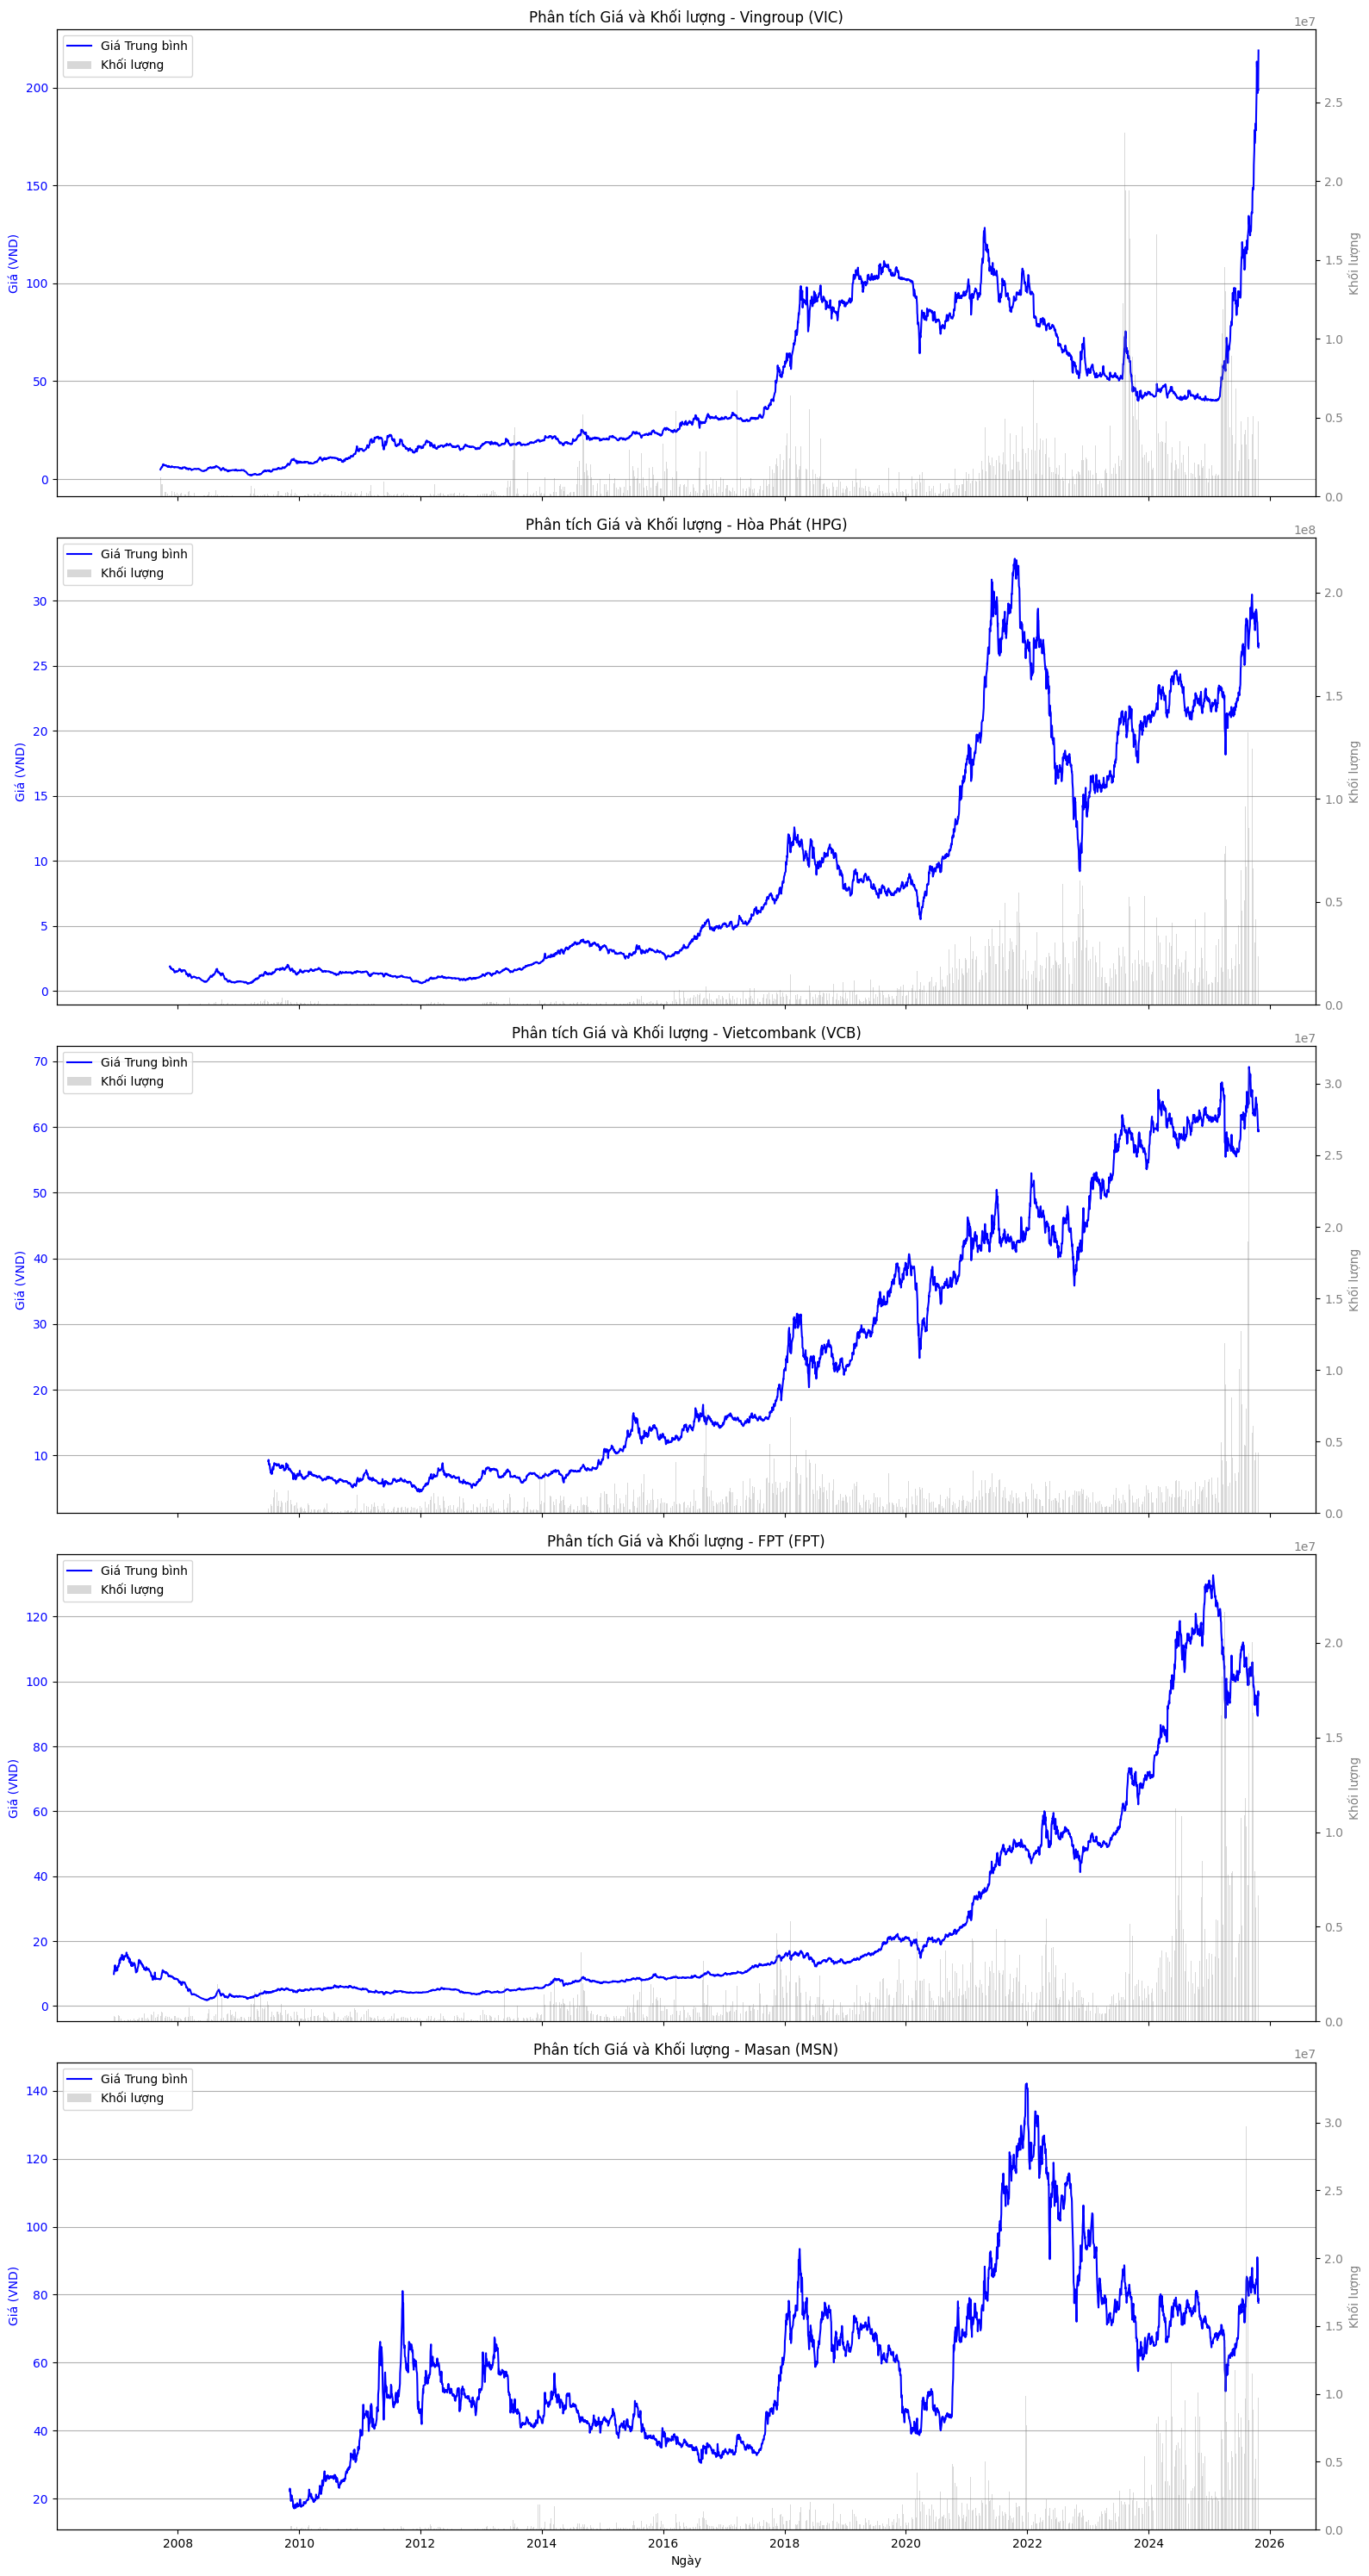

In [20]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(16, 30), sharex=True)

for i in range(len(dfs)):
    ax1 = axes[i]
    df = dfs[i].copy() 
    title = titles[i]

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')
    
    ax1.plot(df['Date'], df['Mean'], color='blue', label='Giá Trung bình')
    ax1.set_ylabel('Giá (VND)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True, axis='y')

    ax2 = ax1.twinx()
    ax2.bar(df['Date'], df['Volume'], color='grey', alpha=0.3, label='Khối lượng')
    ax2.set_ylabel('Khối lượng', color='grey')
    ax2.tick_params(axis='y', labelcolor='grey')
    
    ax1.set_title(f'Phân tích Giá và Khối lượng - {title}')
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')


axes[4].set_xlabel('Ngày')
plt.tight_layout()
plt.show()

# Dự đoán xu hướng giá cổ phiếu

Trong phần này, em sẽ sử dụng dữ liệu giá cổ phiếu Công ty Cổ phần SAM Holdings (mã SAM) làm dữ liệu cho mô hình vì dữ liệu của cổ phiếu SAM là lớn nhất (28/07/2000 đến 26/10/2025). Em dùng dữ liệu từ trước năm 2021 cho việc training và dữ liệu từ năm 2021 cho việc testing.

In [21]:
df = spark.read.format("csv")\
.option("header", "true")\
.option("inferSchema", "true")\
.load("hdfs://namenode:9000/user/root/datackvn/stock_market_data-SAM_2025-10-26.csv")

In [22]:
df.show(5)

+----+----------+----+----+----+-----+-------+
| _c0|      Date|Open|High| Low|Close| Volume|
+----+----------+----+----+----+-----+-------+
|6139|2025-10-24|7.17|7.25|7.01|  7.2| 717700|
|6138|2025-10-23|7.22|7.29|7.15| 7.17| 470700|
|6137|2025-10-22|7.09|7.24|6.92|  7.2| 779300|
|6136|2025-10-21| 6.9| 7.1|6.75| 7.07| 688100|
|6135|2025-10-20| 7.1|7.45|6.85| 6.85|1726000|
+----+----------+----+----+----+-----+-------+
only showing top 5 rows



## Mô hình LSTM đơn biến

In [23]:
from pyspark.sql.functions import expr, col, column

df = df.withColumn("Mean", expr('(High+Low)/2'))

In [24]:
df.show(5)

+----+----------+----+----+----+-----+-------+-----------------+
| _c0|      Date|Open|High| Low|Close| Volume|             Mean|
+----+----------+----+----+----+-----+-------+-----------------+
|6139|2025-10-24|7.17|7.25|7.01|  7.2| 717700|             7.13|
|6138|2025-10-23|7.22|7.29|7.15| 7.17| 470700|7.220000000000001|
|6137|2025-10-22|7.09|7.24|6.92|  7.2| 779300|             7.08|
|6136|2025-10-21| 6.9| 7.1|6.75| 7.07| 688100|            6.925|
|6135|2025-10-20| 7.1|7.45|6.85| 6.85|1726000|             7.15|
+----+----------+----+----+----+-----+-------+-----------------+
only showing top 5 rows



In [25]:
asc_df = df.sort(df.Date.asc())

In [26]:
asc_df.show(5)

+---+----------+----+----+----+-----+------+----+
|_c0|      Date|Open|High| Low|Close|Volume|Mean|
+---+----------+----+----+----+-----+------+----+
|  0|2000-07-28|0.72|0.72|0.72| 0.72|  3200|0.72|
|  1|2000-07-31|0.72|0.72|0.72| 0.72| 10000|0.72|
|  2|2000-08-02|0.74|0.74|0.74| 0.74|   200|0.74|
|  3|2000-08-04|0.75|0.75|0.75| 0.75|  1900|0.75|
|  4|2000-08-07|0.76|0.76|0.76| 0.76|  7300|0.76|
+---+----------+----+----+----+-----+------+----+
only showing top 5 rows



In [27]:
from pyspark.sql.functions import year

df_test = asc_df.filter(year("Date") > 2024)

In [28]:
df_test.show(5)

+----+----------+----+----+----+-----+-------+------------------+
| _c0|      Date|Open|High| Low|Close| Volume|              Mean|
+----+----------+----+----+----+-----+-------+------------------+
|5939|2025-01-02| 7.5| 7.5|7.33| 7.33| 425500|             7.415|
|5940|2025-01-03|7.33|7.33|6.85| 6.85|1420400|              7.09|
|5941|2025-01-06|6.86|6.97| 6.8|  6.8| 449600|             6.885|
|5942|2025-01-07|6.85|6.91|6.72| 6.72| 287800|6.8149999999999995|
|5943|2025-01-08|6.77|6.79|6.68| 6.79| 280700| 6.734999999999999|
+----+----------+----+----+----+-----+-------+------------------+
only showing top 5 rows



In [29]:
df_train = asc_df.subtract(df_test)
df_train.count()

5939

In [30]:
df_train = df_train.sort(df_train.Date.asc())
df_train.show(5)

+---+----------+----+----+----+-----+------+----+
|_c0|      Date|Open|High| Low|Close|Volume|Mean|
+---+----------+----+----+----+-----+------+----+
|  0|2000-07-28|0.72|0.72|0.72| 0.72|  3200|0.72|
|  1|2000-07-31|0.72|0.72|0.72| 0.72| 10000|0.72|
|  2|2000-08-02|0.74|0.74|0.74| 0.74|   200|0.74|
|  3|2000-08-04|0.75|0.75|0.75| 0.75|  1900|0.75|
|  4|2000-08-07|0.76|0.76|0.76| 0.76|  7300|0.76|
+---+----------+----+----+----+-----+------+----+
only showing top 5 rows



In [31]:
dataset_train = df_train.toPandas()

In [32]:
# Import những thư viện cần thiết
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os.path
from os import path
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

In [33]:
from sklearn.preprocessing import MinMaxScaler

In [34]:
training_set = dataset_train.iloc[:, 7:8].values
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

Tạo dữ liệu train, X = 60 time steps, Y =  1 time step, có nghĩa lấy dữ liệu của 60 ngày trước để dự đoán cho ngày tiếp theo hay có thể hiểu là lấy 60 ngày trước làm đầu vào, và đầu ra của mô hình sẽ là ngày tiếp theo

In [35]:
X_train = []
y_train = []
no_of_sample = len(training_set)

for i in range(60, no_of_sample):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [36]:
# Xây dựng model LSTM
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

/opt/conda/envs/stock_price/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [37]:
# Nếu tồn tại model thì load lại nếu không thì thực hiện train 
if path.exists("mymodel.h5"):
    regressor.load_weights("mymodel.h5")
else:
    regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)
    regressor.save("mymodel.h5")

In [38]:
dataset_test = df_test.toPandas()
real_stock_price = dataset_test.iloc[:, 7:8].values

In [39]:
# Tiến hành dự đoán 
dataset_total = pd.concat((dataset_train['Mean'], dataset_test['Mean']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
no_of_sample = len(inputs)

for i in range(60, no_of_sample):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


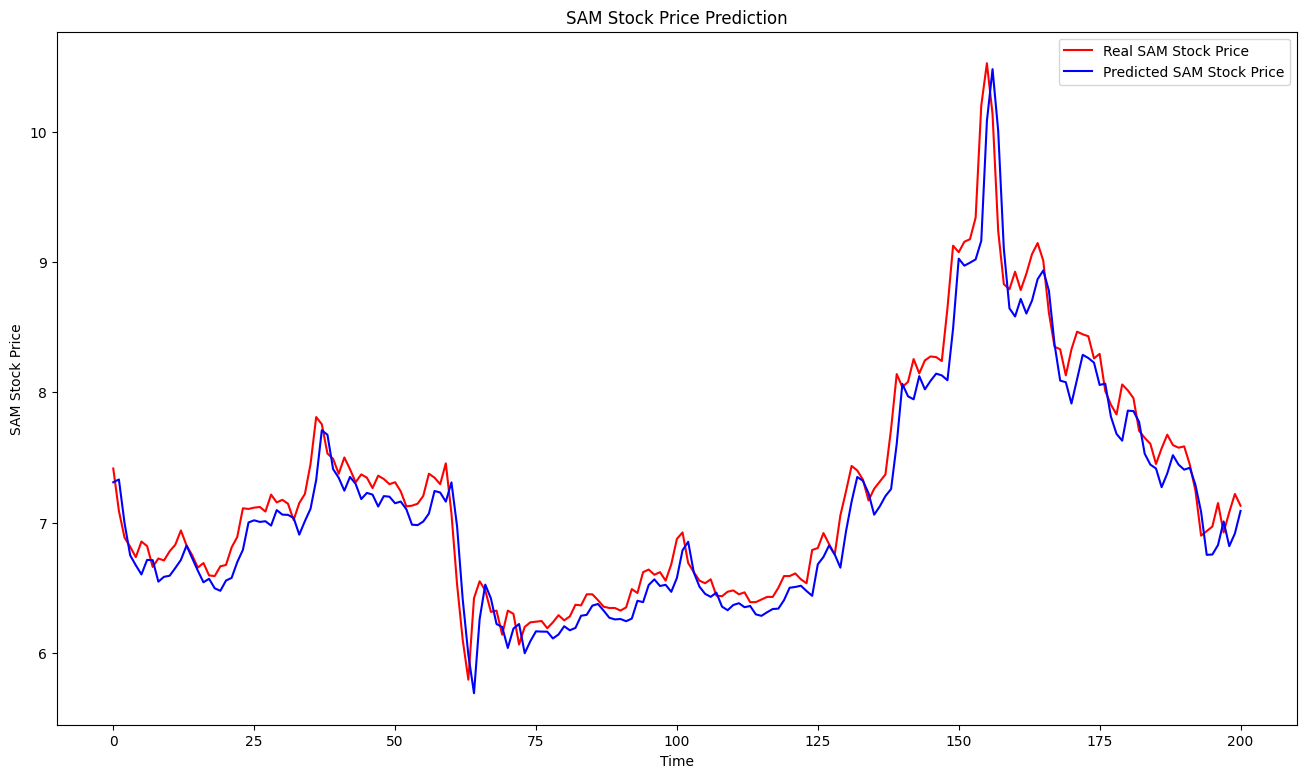

In [40]:
plt.figure(figsize=(16,9))
plt.plot(real_stock_price, color = 'red', label = 'Real SAM Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted SAM Stock Price')
plt.title('SAM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('SAM Stock Price')
plt.legend()
plt.show()

## Mô hình LSTM đa biến

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import os.path
from os import path

In [42]:
# Chuẩn bị dữ liệu
dataset_train_pd = df_train.toPandas()
dataset_train_pd['Date'] = pd.to_datetime(dataset_train_pd['Date'])
dataset_train_pd = dataset_train_pd.sort_values('Date').reset_index(drop=True)
dataset_train_pd['Volume'] = pd.to_numeric(dataset_train_pd['Volume'], errors='coerce')

# Tính các đặc trưng mới
dataset_train_pd['Mean'] = (dataset_train_pd['High'] + dataset_train_pd['Low']) / 2
dataset_train_pd['SMA_10'] = dataset_train_pd['Mean'].rolling(window=10).mean()
dataset_train_pd['EMA_20'] = dataset_train_pd['Mean'].ewm(span=20, adjust=False).mean()

# Xử lý giá trị NaN (sinh ra do tính rolling/ewm)
dataset_train_pd = dataset_train_pd.bfill() # Điền ngược để lấp đầy các NaN ở đầu

# Danh sách các đặc trưng đầu vào (features) và mục tiêu (target)
# Chúng ta sẽ dùng 8 đặc trưng để dự đoán 1 mục tiêu
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Mean', 'SMA_10', 'EMA_20']
target_col = 'Mean' # Mục tiêu dự đoán là 'Mean'

# Lấy các giá trị (values) của các cột này
training_set_features = dataset_train_pd[features].values
training_set_target = dataset_train_pd[[target_col]].values

# Tạo 2 Scaler riêng biệt: 1 cho features, 1 cho target
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

# Fit và transform dữ liệu huấn luyện
scaled_train_features = scaler_features.fit_transform(training_set_features)
scaled_train_target = scaler_target.fit_transform(training_set_target)

In [43]:
X_train = []
y_train = []
timesteps = 60 # Sử dụng 60 ngày quá khứ

for i in range(timesteps, len(scaled_train_features)):
    # X_train là 1 cửa sổ 60 ngày, mỗi ngày có 8 đặc trưng
    X_train.append(scaled_train_features[i-timesteps:i, :]) 
    
    # y_train là giá trị Mean (mục tiêu) của ngày tiếp theo
    y_train.append(scaled_train_target[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape X_train: (số mẫu, 60 time steps, 8 features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(features)))
print(X_train.shape)

(5879, 60, 8)


In [44]:
model_filename = "mymodel_multivariate.h5"
regressor = Sequential()

# Lớp LSTM đầu tiên: Cập nhật input_shape thành (60, 8)
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

# Các lớp LSTM tiếp theo
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Lớp Output
regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.summary() # In ra cấu trúc mô hình

/opt/conda/envs/stock_price/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 50)         │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,451 (283.01 KB)

 Trainable params: 72,451 (283.01 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# Huấn luyện mô hình
if path.exists(model_filename):
    print(f"Đang tải mô hình đã lưu từ {model_filename}...")
    regressor.load_weights(model_filename)
else:
    print(f"Đang huấn luyện mô hình mới (epochs=100)...")
    regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)
    regressor.save(model_filename)
    print(f"Đã lưu mô hình vào {model_filename}")

Đang tải mô hình đã lưu từ mymodel_multivariate.h5...


In [46]:
# Tải và sắp xếp test set
dataset_test_pd = df_test.toPandas()
dataset_test_pd['Date'] = pd.to_datetime(dataset_test_pd['Date'])
dataset_test_pd = dataset_test_pd.sort_values('Date').reset_index(drop=True)

# Lấy 60 ngày cuối của tập train cho test set
inputs_data = dataset_train_pd.tail(timesteps)
# Nối test set vào
dataset_total_pd = pd.concat([inputs_data, dataset_test_pd], axis=0)

# Tính toán các đặc trưng cho bộ dữ liệu tổng hợp này
dataset_total_pd['Mean'] = (dataset_total_pd['High'] + dataset_total_pd['Low']) / 2
dataset_total_pd['Volume'] = pd.to_numeric(dataset_total_pd['Volume'], errors='coerce')
dataset_total_pd['SMA_10'] = dataset_total_pd['Mean'].rolling(window=10).mean()
dataset_total_pd['EMA_20'] = dataset_total_pd['Mean'].ewm(span=20, adjust=False).mean()

# Fillna cho các giá trị NaN có thể phát sinh ở đoạn nối
dataset_total_pd = dataset_total_pd.bfill()

# Lấy các giá trị features
total_inputs_features = dataset_total_pd[features].values

# Scale dữ liệu test BẰNG SCALER CỦA TẬP TRAIN (scaler_features)
scaled_inputs_features = scaler_features.transform(total_inputs_features)

# Tạo X_test
X_test = []
for i in range(timesteps, len(scaled_inputs_features)):
    X_test.append(scaled_inputs_features[i-timesteps:i, :])

X_test = np.array(X_test)
print(f"Hình dạng X_test (đa biến): {X_test.shape}")

# Lấy giá thực tế (real_stock_price) từ cột 'Mean' của test_df
# Cần tính 'Mean' cho test_df một cách riêng biệt để so sánh
dataset_test_pd['Mean'] = (dataset_test_pd['High'] + dataset_test_pd['Low']) / 2
real_stock_price = dataset_test_pd[[target_col]].values

Hình dạng X_test (đa biến): (201, 60, 8)


7/7 ━━━━━━━━━━━━━━━━━━━━ -11s 65ms/step     


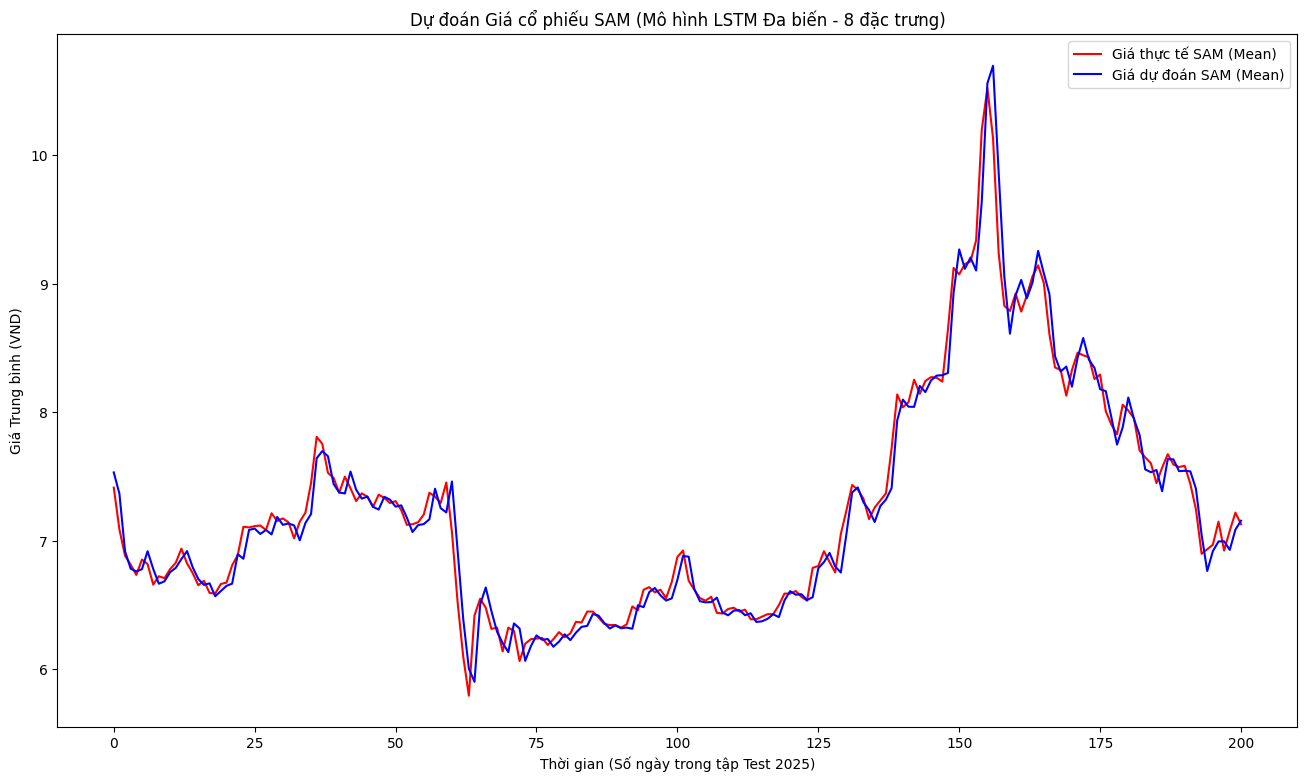

In [47]:
predicted_stock_price_scaled = regressor.predict(X_test)

# Đảo ngược Scaling (scaler_target)
predicted_stock_price = scaler_target.inverse_transform(predicted_stock_price_scaled)

# Vẽ biểu đồ
plt.figure(figsize=(16, 9))
plt.plot(real_stock_price, color = 'red', label = 'Giá thực tế SAM (Mean)')
plt.plot(predicted_stock_price, color = 'blue', label = 'Giá dự đoán SAM (Mean)')
plt.title('Dự đoán Giá cổ phiếu SAM (Mô hình LSTM Đa biến - 8 đặc trưng)')
plt.xlabel('Thời gian (Số ngày trong tập Test 2025)')
plt.ylabel('Giá Trung bình (VND)')
plt.legend()
plt.show()

In [48]:
spark.stop()

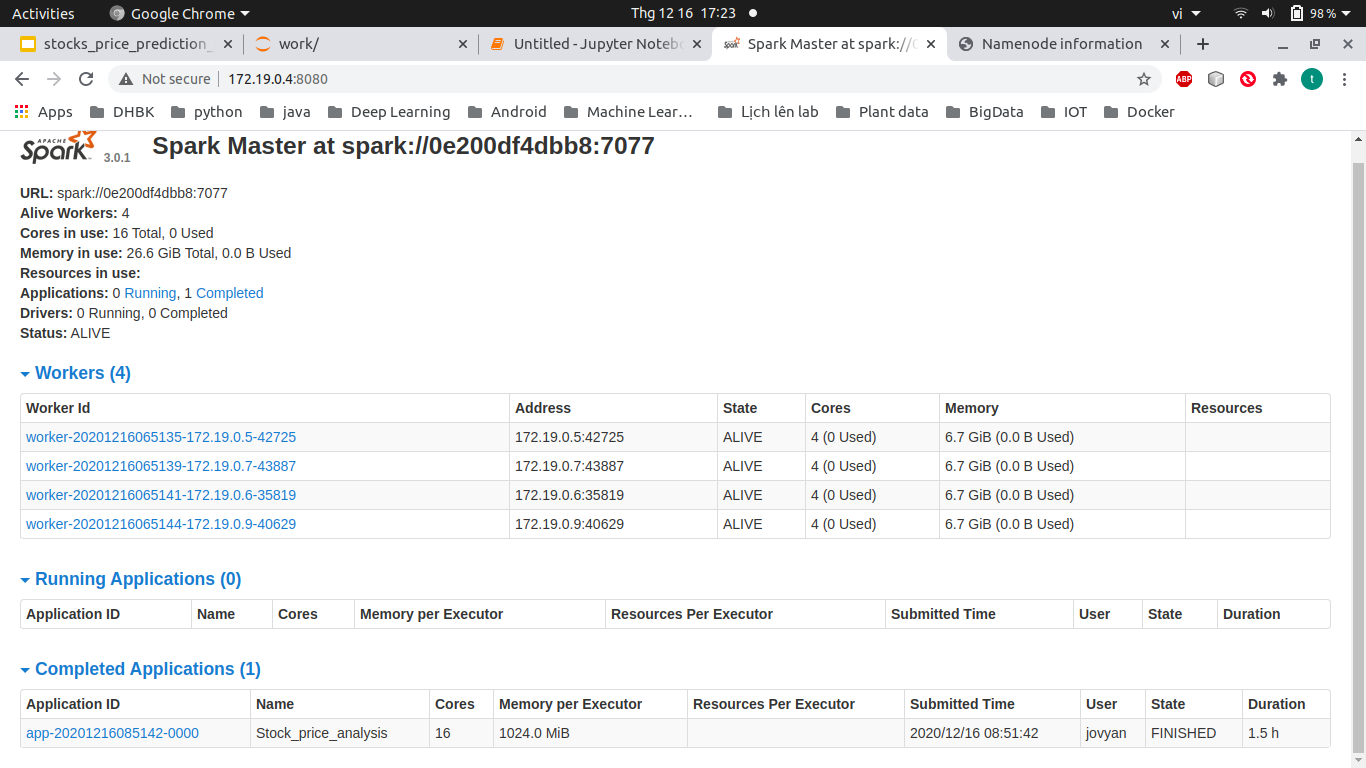

In [49]:
Image("spark_st.png")